<a href="https://colab.research.google.com/github/nlee98/ADS-505-Business-Analytics/blob/main/ADS_505_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS-505 Final Project
By Group 2 - Mohammad	Mahmoudighaznavi, Nicholas Lee, and Christine	Vu

In [1]:
# Packages #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV

from google.colab import files

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
# Import Data Sets via Upload
uploaded = files.upload()

Saving airline_satisfaction_test.csv to airline_satisfaction_test.csv


In [5]:
# Import training set
airline_train = pd.read_csv(
    "airline_satisfaction_train.csv"
)

# Import test set
airline_test = pd.read_csv(
    "airline_satisfaction_test.csv"
)

In [ ]:
airline_train = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_train.csv?token=GHSAT0AAAAAABY77FMSTZO2OCABMALPR6NEYZJ4POA"
)
airline_test = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_test.csv?token=GHSAT0AAAAAABY77FMT36XI4QAT2J2XROGQYZJ4PPA"
)

In [6]:
airline_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [7]:
airline_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


# Exploratory Data Analysis (EDA)

In [24]:
# Check for missing values in the training set
print(airline_train.isnull().sum())

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [25]:
# Check for missing values in the test set
print(airline_test.isnull().sum())

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


Both the training set and test set are missing values for the predictor "Arrival Delay in Minutes." The training set is missing 310 values for the predictor and the test set is missing 83 values for the predictor.

## Categorical Predictors ##

### Barcharts of Customers by Gender and Customer Type 

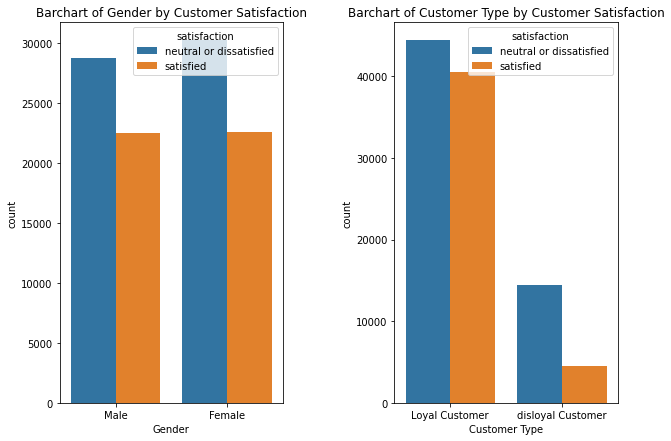

In [ ]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (10, 7)
)

plt.subplot(1,2,1)
sns.countplot(x = airline_train["Gender"],
              hue = airline_train["satisfaction"]);
plt.title("Barchart of Gender by Customer Satisfaction")

plt.subplot(1,2,2)
sns.countplot(x = airline_train["Customer Type"],
              hue = airline_train["satisfaction"])
plt.title("Barchart of Customer Type by Customer Satisfaction")

fig.subplots_adjust(wspace = 0.5)
plt.show()

### Barcharts of Type of Travel and (Ticket) Class 

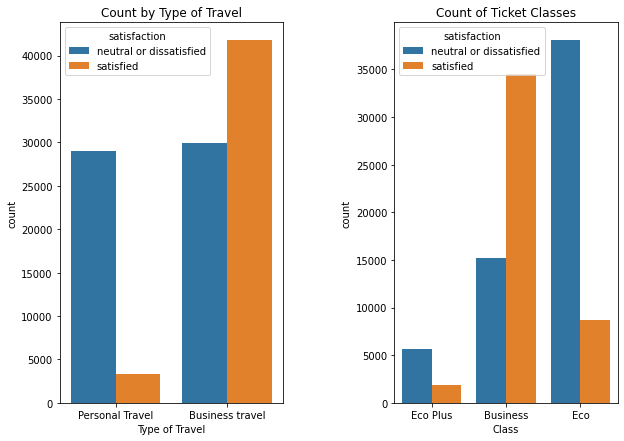

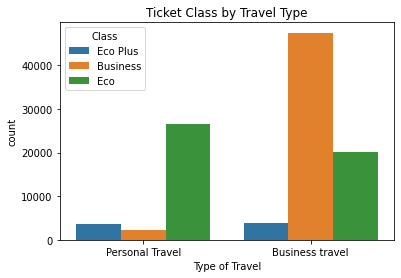

In [ ]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (10, 7)
)
# Count Plot of Type of Travel predictor
plt.subplot(1,2,1)
sns.countplot(x = airline_train["Type of Travel"],
              hue = airline_train["satisfaction"])
plt.title("Count by Type of Travel")

# Count Plot of (Ticket) Class predictor
plt.subplot(1,2,2)
sns.countplot(x = airline_train["Class"],
              hue = airline_train["satisfaction"])
plt.title("Count of Ticket Classes")

fig.subplots_adjust(wspace = 0.5)
plt.show()

# Countplot of Type of Travel by (Ticket) Class
sns.countplot(airline_train["Type of Travel"],
              hue = airline_train["Class"]);
plt.title("Ticket Class by Travel Type")
plt.show()

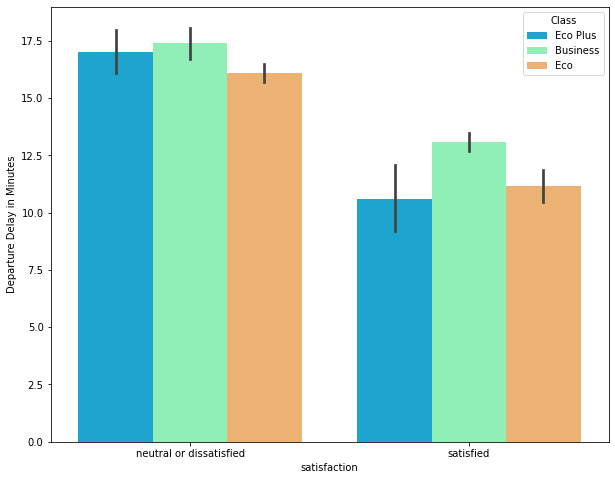

In [ ]:
# Satisfaction by Flight Delay
plt.figure(figsize = (10, 8))

sns.barplot(x = "satisfaction",
            y = "Departure Delay in Minutes",
            data = airline_train,
            palette = "rainbow",
            hue = "Class")

plt.show()

## Numerical Predictors

### Distribution of Age

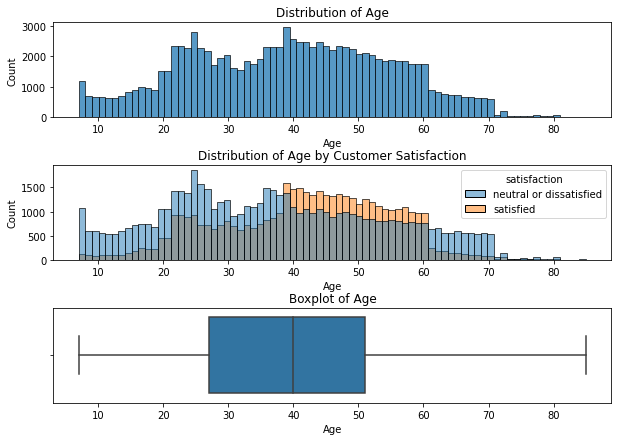

The median age is 40.0000
The average age is 39.3797


In [ ]:
fig, axes = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10, 7)
)

plt.subplot(3,1,1)
sns.histplot(airline_train["Age"]);
plt.title("Distribution of Age")

plt.subplot(3,1,2)
sns.histplot(x = airline_train["Age"],
            hue = airline_train["satisfaction"]);
plt.title("Distribution of Age by Customer Satisfaction")

plt.subplot(3,1,3)
sns.boxplot(airline_train["Age"])
plt.title("Boxplot of Age")

fig.subplots_adjust(hspace = 0.5)
plt.show()

# Descriptive Statistics to Assess Normality
age_median = np.median(airline_train["Age"])
age_avg = np.average(airline_train["Age"])
print("The median age is %.4f" % age_median)
print("The average age is %.4f" % age_avg)

### Distribution of Flight Distance

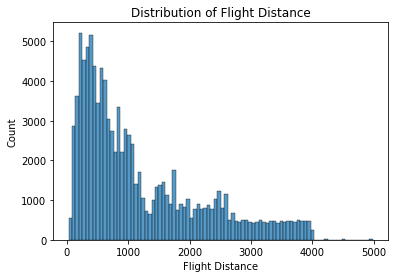

In [ ]:
# Histogram of Flight Distance
sns.histplot(airline_train["Flight Distance"]);
plt.title("Distribution of Flight Distance")
plt.show()

The feature, Flight Distance, is heavily skewed right. The predictor will be transformed if a model demands normally distributed features.

# Pre-Processing #

In [ ]:
# Drop ID Columns
airline_train = airline_train.drop(["id"], axis = 1)
airline_test = airline_test.drop(["id"], axis = 1)

In [26]:
# Resolve Missing Values

# Model Training

## Decision Tree ##

## Random Forest ##

## Logistic Regression ##

## Linear Discriminant Analysis ##